In [1]:
import numpy as np
import pandas as pd

import sys
import cv2   #opencv-python
#from skimage.io import imread, imread_collection
from scipy import signal
import scipy.misc
from scipy.misc import imread
from scipy.ndimage import filters,distance_transform_edt
from matplotlib import pyplot as plt

import os
from os import listdir

from keras.models import Model
from keras import optimizers
from keras.layers import Input,Activation,Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization,Dropout

/Users/cnb331/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
listdir('/Users/cnb331/github/single_cell_segmentation/T47D_fluorescence')

['train_test_data',
 'training_data',
 'CCA_evaluation',
 'T47D_weight_file',
 'pixel_evaluation']

In [12]:
#dir_path='/home/zoro/Desktop/nmumg_data'
dir_path ='/Users/cnb331/github/single_cell_segmentation/T47D_fluorescence'#blueberry, works
#dir_path ='/Users/cnb331/github/single_cell_segmentation/NMuMg_phase_contrast'#blueberry, works

main_path=dir_path+'/train_test_data/distance_transform'
path_train_input =main_path+'/train/Img'
path_test_input=main_path+'/test/Img'
path_train_gt = main_path+'/train/Bwdist'
path_test_gt=main_path+'/test/Bwdist'

listdir(path_train_input)

path_predict=dir_path+'/predict'
path_output=dir_path+'/output'
path_frcnn_predict=dir_path+'/frcnn_predict'

nb_epoch =3
batch_size = 10
weight_file='T47D_reg_ep300.hdf5'

In [13]:
listdir(path_train_input)
#dir(listdir)

['crop1002t1xy12c2s7.tif',
 'crop1002t1xy14c2s13.tif',
 'crop1002t1xy03c2s2.tif',
 'crop1002t1xy13c2s2.tif',
 'crop1002t1xy13c2s3.tif',
 'crop1002t1xy03c2s3.tif',
 'crop1002t1xy14c2s12.tif',
 'crop1002t1xy02c2s6.tif',
 'crop1002t1xy12c2s6.tif',
 'crop1002t1xy02c2s4.tif',
 'crop1002t1xy12c2s4.tif',
 'crop1002t1xy14c2s10.tif',
 'crop1002t1xy13c2s1.tif',
 'crop1002t1xy03c2s1.tif',
 'crop1002t1xy03c2s0.tif',
 'crop1002t1xy13c2s0.tif',
 'crop1002t1xy14c2s11.tif',
 'crop1002t1xy12c2s5.tif',
 'crop1002t1xy02c2s5.tif',
 'crop1002t1xy02c2s1.tif',
 'crop1002t1xy12c2s1.tif',
 'crop1002t1xy14c2s15.tif',
 'crop1002t1xy13c2s4.tif',
 'crop1002t1xy03c2s4.tif',
 'crop1002t1xy03c2s5.tif',
 'crop1002t1xy13c2s5.tif',
 'crop1002t1xy14c2s14.tif',
 'crop1002t1xy12c2s0.tif',
 'crop1002t1xy02c2s0.tif',
 'crop1002t1xy12c2s2.tif',
 'crop1002t1xy02c2s2.tif',
 'crop1002t1xy14c2s16.tif',
 'crop1002t1xy03c2s7.tif',
 'crop1002t1xy03c2s6.tif',
 'crop1002t1xy14c2s17.tif',
 'crop1002t1xy02c2s3.tif',
 'crop1002t1xy12c2s3

In [14]:
#As this is a regression problem, train_label should be also normalized.
def prep_data(path_img,path_gt):
    data = []
    label = []

    img_list = sorted(listdir(path_img))
    gt_list=sorted(listdir(path_gt))
    i=0
    while (i<len(img_list)):
        img = np.array(imread(path_img +'/'+ img_list[i]),dtype=np.float64)
        #img = np.array(imread(path_img +'/'+ img_list[i]))
        #print img.shape
        img=(img-np.amin(img))*1.0/(np.amax(img)-np.amin(img))#img*1.0 transform array to double
        img=img*1.0/np.median(img)
        img_h=img.shape[0]        
        img_w=img.shape[1]        
        img=np.reshape(img,(img_h,img_w,1))         
        data.append(img)  
        
        gt =np.array(imread(path_gt + '/'+ gt_list[i]))
#---------------with or without normalization-----------------------        
        if np.count_nonzero(gt)!=0:
            nonzero_gt=gt[gt>0]
            gt=gt*1.0/np.median(nonzero_gt)

        gt=np.reshape(gt,(img_h,img_w,1))
        label.append(gt)
        
        i+=1
    data=np.array(data)
    label=np.array(label) 
    print (data.shape, label.shape)
    return data, label     

In [15]:
def prep_prediction_data(path_img):
    data = []
    img_list = sorted(listdir(path_img))
    i=0
    while (i<len(img_list)):
        img = np.array(imread(path_img +'/'+ img_list[i]),dtype=np.float64)
        img=(img-np.amin(img))*1.0/(np.amax(img)-np.amin(img))#img*1.0 transform array to double
        img=img*1.0/np.median(img)
        img_h=img.shape[0]        
        img_w=img.shape[1]
        img=np.reshape(img,(img_h,img_w,1))
        data.append(img)
        i+=1
    data=np.array(data)
    return data

In [16]:
def conv_block(input_tensor, kernel, filters):
    x=Conv2D(filters, (kernel, kernel), padding='same')(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    return x

In [17]:
kernel = 3
#------------encoder layers--------------------------------
inputs = Input((None,None, 1))
conv1=conv_block(inputs,kernel,filters=64)
conv1=conv_block(conv1,kernel,filters=64)
pool1=MaxPooling2D()(conv1)
    
conv2=conv_block(pool1,kernel,filters=128)
conv2=conv_block(conv2,kernel,filters=128)
pool2=MaxPooling2D()(conv2)

conv3=conv_block(pool2,kernel,filters=256)
conv3=conv_block(conv3,kernel,filters=256)
conv3=conv_block(conv3,kernel,filters=256)
pool3=MaxPooling2D()(conv3)

conv4=conv_block(pool3,kernel,filters=512)
conv4=conv_block(conv4,kernel,filters=512)
conv4=conv_block(conv4,kernel,filters=512)
pool4=MaxPooling2D()(conv4)
 
conv5=conv_block(pool4,kernel,filters=512)
conv5=conv_block(conv5,kernel,filters=512)
conv5=conv_block(conv5,kernel,filters=512)
pool5=MaxPooling2D()(conv5)


#--------------------decoder layers--------------------------

up6=UpSampling2D()(pool5)
conv6=conv_block(up6,kernel,filters=512)
conv6=conv_block(conv6,kernel,filters=512)
conv6=conv_block(conv6,kernel,filters=512)

up7=UpSampling2D()(conv6)
conv7=conv_block(up7,kernel,filters=512)
conv7=conv_block(conv7,kernel,filters=512)
conv7=conv_block(conv7,kernel,filters=512)
    
up8=UpSampling2D()(conv7)
conv8=conv_block(up8,kernel,filters=256)
conv8=conv_block(conv8,kernel,filters=256)
conv8=conv_block(conv8,kernel,filters=256)

up9=UpSampling2D()(conv8)
conv9=conv_block(up9,kernel,filters=128)
conv9=conv_block(conv9,kernel,filters=128)

up10=UpSampling2D()(conv9)
conv10=conv_block(up10,kernel,filters=64)

conv11=conv_block(conv10,kernel=1,filters=1)    
outputs=Activation('relu')(conv11)

autoencoder=Model(inputs=[inputs], outputs=[outputs])

#autoencoder.summary()

autoencoder.compile(loss="mean_squared_error", optimizer='adam', metrics=['mae','acc'])
print ('Compiled: OK')

Compiled: OK


In [18]:
train_data, train_label = prep_data(path_train_input,path_train_gt)

/Users/cnb331/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/cnb331/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


(131, 256, 256, 1) (131, 256, 256, 1)


In [19]:
#---------------------train-------------------------
history=autoencoder.fit(train_data, train_label, batch_size=batch_size, epochs=nb_epoch, verbose=1)
autoencoder.save_weights(weight_file)

Epoch 1/3
131/131 [==============================] - 693s 5s/step - loss: 0.8525 - mean_absolute_error: 0.6246 - acc: 0.2660
Epoch 2/3
131/131 [==============================] - 714s 5s/step - loss: 0.7018 - mean_absolute_error: 0.5635 - acc: 0.2788
Epoch 3/3
131/131 [==============================] - 711s 5s/step - loss: 0.6124 - mean_absolute_error: 0.5237 - acc: 0.2963


In [26]:
print(path_predict)

listdir(path_predict)

/Users/cnb331/github/single_cell_segmentation/T47D_fluorescence/predict


['Img', 'Bwdist']

/Users/cnb331/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/Users/cnb331/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/cnb331/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


<class 'numpy.ndarray'>
(13, 256, 256, 1)
(256, 256)


/Users/cnb331/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/Users/cnb331/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


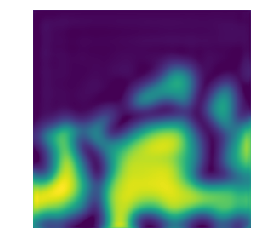

In [31]:
#-------------------predict----------------------------
#autoencoder.load_weights(weight_file)
autoencoder.load_weights("/Users/cnb331/github/single_cell_segmentation/T47D_fluorescence/T47D_weight_file/T47D_reg_ep300.hdf5")

predict_data=prep_prediction_data(path_predict)
output = autoencoder.predict(predict_data, verbose=0)
print(type(output))
print(output.shape)

#output_label=np.argmax(output[0],axis=-1)
im=output[0][:,:,0]   
np.save(path_output+'/reg_out.npy',im)
data=np.load(path_output+'/reg_out.npy')
print(im.shape)

#save image to 8 bit
scipy.misc.imsave(path_output+'/reg_out_8bit.png',im)
#save image to the exat value

img=scipy.misc.toimage(im,high=np.max(im),low=np.min(im),mode='F')
img.save(path_output+'/reg_out_exact.tif')
img.save(path_frcnn_predict+'/reg_out_exact.tif')
plt.imshow(im)
plt.axis('off')
plt.savefig(path_output+'/reg_out_300dpi.tif',bbox_inches='tight',format='tif',dpi=300)
plt.show()

In [28]:
dir_path

'/Users/cnb331/github/single_cell_segmentation/T47D_fluorescence'